In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# Reading the df
loan_df = pd.read_csv('../raw_data/loan_data_2007_2014.csv')

/tmp/ipykernel_2435/2387733730.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_df = pd.read_csv('../raw_data/loan_data_2007_2014.csv')


In [3]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

## Duplicates and Correlation

In [4]:
# N of rows

print(
    len(loan_df)
    , loan_df.duplicated().sum()
)

# No duplicated columns

466285 0


## Dataset Exploration

In [5]:
# We already know how we want our target variable to be. Creating the target variable
loan_df['loan_status'].value_counts(dropna = False)

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [6]:
# Encoding the target variable
loan_df['good_bad'] = np.where(loan_df['loan_status'].isin(['Charged Off', 'Default',
                                                       'Does not meet the credit policy. Status:Charged Off',
                                                       'Late (31-120 days)']), 0, 1)

# We create a new variable that has the value of '0' if a condition is met, and the value of '1' if it is not met.

loan_df['good_bad'].value_counts()

1    415317
0     50968
Name: good_bad, dtype: int64

In [7]:
round((loan_df['good_bad'] == 0).sum()/len(loan_df), 2)

0.11

In [8]:
# Counting the number of NaN for each column
#loan_df.isnull().sum().sort_values(ascending=False) 
for col in loan_df.columns:
    print(f"{round(float(loan_df[col].isnull().sum()/len(loan_df[col]))*100)}% Missing Values on Column {col}")

0% Missing Values on Column Unnamed: 0
0% Missing Values on Column id
0% Missing Values on Column member_id
0% Missing Values on Column loan_amnt
0% Missing Values on Column funded_amnt
0% Missing Values on Column funded_amnt_inv
0% Missing Values on Column term
0% Missing Values on Column int_rate
0% Missing Values on Column installment
0% Missing Values on Column grade
0% Missing Values on Column sub_grade
6% Missing Values on Column emp_title
5% Missing Values on Column emp_length
0% Missing Values on Column home_ownership
0% Missing Values on Column annual_inc
0% Missing Values on Column verification_status
0% Missing Values on Column issue_d
0% Missing Values on Column loan_status
0% Missing Values on Column pymnt_plan
0% Missing Values on Column url
73% Missing Values on Column desc
0% Missing Values on Column purpose
0% Missing Values on Column title
0% Missing Values on Column zip_code
0% Missing Values on Column addr_state
0% Missing Values on Column dti
0% Missing Values on C

In [9]:
# emp_title
# loan_df['emp_title'].unique()
print(
    loan_df['emp_title'].value_counts(dropna=False)
    , loan_df[loan_df['emp_title'].isna()].groupby('emp_length').size().reset_index(name='N')
)
# Tem muito emp_title NA que tem resposta no emp_length. Também não tem como encodar as classes de forma satisfatória. Então vamos usar o emp_length. DROP

NaN                                  27588
Teacher                               5399
Manager                               4438
Registered Nurse                      2316
RN                                    2204
                                     ...  
SEA Group, llc                           1
The Eastern Arizona AHEC                 1
Delaware Quarries.com                    1
McCauley trucking and warehousing        1
Server Engineer Lead                     1
Name: emp_title, Length: 205476, dtype: int64    emp_length     N
0      1 year   230
1   10+ years  2682
2     2 years   403
3     3 years   555
4     4 years   452
5     5 years   521
6     6 years   376
7     7 years   407
8     8 years   313
9     9 years   210
10   < 1 year   617


In [10]:
# emp_length
loan_df['emp_length'].value_counts(dropna = False)
# O que são os NAs? Desempregado?
# Encode -> emprego estável

# vendo a frequência de valores de annual_inc para os casos em que emp_length é NA:
# loan_df[loan_df['emp_length'].isna()].groupby('annual_inc').size().reset_index(name='N')

# Média de renda anual dos casos em que emp_length é NA
print(
    f'''
    Renda média dos casos com emp_length NA = {round(np.mean(loan_df[loan_df['emp_length'].isna()]['annual_inc']), 2)}
    Renda média das categorias de emp_length 
    {loan_df.groupby('emp_length')['annual_inc'].mean()}
    '''
)

# O NA tem uma renda anual bem menor que os outros (49k vs 68k) --> encode como indefinido/unemployed
# OU -> fazer categorias menos amplas




    Renda média dos casos com emp_length NA = 49428.98
    Renda média das categorias de emp_length 
    emp_length
1 year       69023.265835
10+ years    80190.099830
2 years      70951.243257
3 years      71749.489683
4 years      71573.293625
5 years      72330.766718
6 years      71982.835566
7 years      73108.203561
8 years      74064.827391
9 years      74385.958024
< 1 year     68301.848520
Name: annual_inc, dtype: float64
    


In [11]:
# Vendo a % de good e bad por categoria de emp_length
loan_df.groupby('emp_length', dropna = False)['good_bad'].value_counts(normalize=True)

# % muito mais alta nos NAs e no < 1 year
# -> Tiebreak with WEIGHT OF EVIDENCE

emp_length  good_bad
1 year      1           0.888124
            0           0.111876
10+ years   1           0.900353
            0           0.099647
2 years     1           0.890242
            0           0.109758
3 years     1           0.890480
            0           0.109520
4 years     1           0.890411
            0           0.109589
5 years     1           0.885033
            0           0.114967
6 years     1           0.882889
            0           0.117111
7 years     1           0.888655
            0           0.111345
8 years     1           0.889931
            0           0.110069
9 years     1           0.887914
            0           0.112086
< 1 year    1           0.881015
            0           0.118985
NaN         1           0.867384
            0           0.132616
Name: good_bad, dtype: float64

In [12]:
loan_df['desc'].unique()
# Coluna muito caótica. Dropar

array(['  Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>',
       '  Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br>  Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>',
       nan, ...,
       '  Borrower added on 12/09/13 > consolidate all credit accounts<br>',
       '  Borrower added on 12/06/13 > I am going to consolidate a credit card debt from medical and moving expenses with a loan I already have. I have paid everything on time for years, I just need to eliminate this

In [13]:
loan_df['mths_since_last_delinq'].unique()
# O que significa o NA nessa coluna? Não tem descrição. Dropar.
# mths_since_last_record idem

array([ nan,  35.,  38.,  61.,   8.,  20.,  18.,  68.,  45.,  48.,  41.,
        40.,  74.,  25.,  53.,  39.,  10.,  26.,  56.,  77.,  28.,  52.,
        24.,  16.,  60.,  54.,  23.,   9.,  11.,  13.,  65.,  19.,  80.,
        22.,  59.,  79.,  44.,  64.,  57.,  14.,  63.,  49.,  15.,  73.,
        70.,  29.,  51.,   5.,  75.,  55.,   2.,  30.,  47.,  33.,  69.,
         4.,  43.,  21.,  27.,  46.,  81.,  78.,  82.,  31.,  76.,  62.,
        72.,  42.,  50.,   3.,  12.,  67.,  36.,  34.,  58.,  17.,  71.,
        66.,  32.,   6.,  37.,   7.,   1.,  83.,  86., 115.,  96., 103.,
       120., 106.,  89., 107.,  85.,  97.,  95.,   0., 110.,  84., 135.,
        88.,  87., 122.,  91., 146., 134., 114.,  99.,  93., 127., 101.,
        94., 102., 129., 113., 139., 131., 156., 143., 109., 119., 149.,
       118., 130., 148., 126.,  90., 141., 116., 100., 152.,  98.,  92.,
       108., 133., 104., 111., 105., 170., 124., 136., 180., 188., 140.,
       151., 159., 121.])

In [14]:
loan_df['next_pymnt_d'].unique() # Sem interpretação do que são os NAs -> DROP

array([nan, 'Feb-16', 'Jan-16', 'Sep-13', 'Feb-14', 'May-14', 'Jun-13',
       'Mar-12', 'Apr-12', 'May-13', 'Aug-12', 'Aug-13', 'Jun-12',
       'Nov-13', 'Feb-12', 'Oct-11', 'Jan-13', 'Jan-14', 'Jul-13',
       'Jul-15', 'Jan-12', 'Dec-12', 'Jun-11', 'Feb-13', 'Nov-11',
       'Nov-12', 'Dec-11', 'Aug-11', 'Sep-11', 'Apr-11', 'Mar-14',
       'Apr-13', 'Mar-11', 'Jul-12', 'Aug-14', 'Oct-13', 'Sep-12',
       'May-12', 'Apr-15', 'Jul-11', 'Dec-15', 'Dec-13', 'Jan-11',
       'Oct-12', 'Nov-14', 'Mar-13', 'Aug-15', 'Feb-15', 'May-15',
       'Jul-14', 'Nov-15', 'Sep-14', 'Oct-15', 'May-11', 'Feb-11',
       'Dec-14', 'Jun-15', 'Apr-14', 'Jan-15', 'Sep-15', 'Jun-14',
       'Nov-10', 'Oct-10', 'Dec-10', 'Mar-15', 'Oct-14', 'Jul-10',
       'Sep-10', 'May-10', 'Aug-10', 'Mar-10', 'Jun-10', 'Apr-10',
       'Feb-10', 'Dec-09', 'Nov-09', 'Oct-09', 'Jan-10', 'Sep-09',
       'Jun-09', 'Aug-09', 'Jul-09', 'May-09', 'Apr-09', 'Jan-09',
       'Oct-08', 'Feb-09', 'Nov-08', 'Sep-08', 'Mar-09', 

In [15]:
# Total collection amounts ever owed -> Tem 0 e tem NA. Valor padrão na coluna é zero (346.259). Imputar com zero.
loan_df['tot_coll_amt'].unique()
loan_df['tot_coll_amt'].value_counts(dropna = False)
loan_df['tot_coll_amt'].median()
# loan_df[['tot_coll_amt']].boxplot()

# loan_df.groupby('good_bad')['tot_coll_amt'].mean()

# Muitos outliers -> Robust scaler e impute median

0.0

In [16]:
# Total current balance of all accounts. 15% de NA. Variável boa, pq é uma medida do poder de pagamento.
loan_df['tot_cur_bal'].value_counts()

# IMPUTAR com média ou mediana?
print(f"Mean = {loan_df['tot_cur_bal'].mean()}\nMedian = {loan_df['tot_cur_bal'].median()}")

# Mediana talvez seja melhor

Mean = 138801.71338530185
Median = 81539.0


<AxesSubplot:>

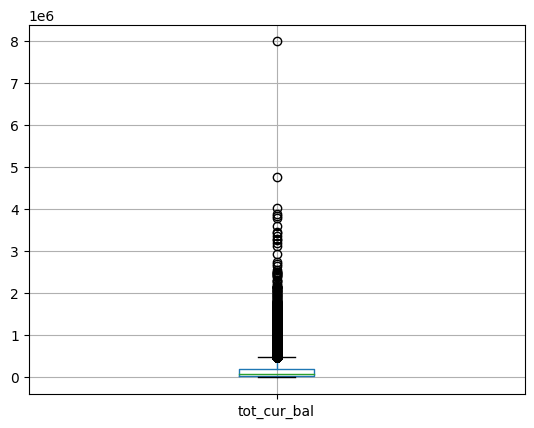

In [17]:
loan_df[['tot_cur_bal']].boxplot()
# Muito outlier -> Robust!

In [18]:
# Total revolving high credit/ credit limit
loan_df['total_rev_hi_lim'].value_counts()

# IMPUTAR com média ou mediana?
print(f"Mean = {loan_df['total_rev_hi_lim'].mean()}\nMedian = {loan_df['total_rev_hi_lim'].median()}")

Mean = 30379.087770732483
Median = 22800.0


In [19]:
loan_df[['total_rev_hi_lim']].boxplot()
# muito outlier. Min/Max

<AxesSubplot:>

In [20]:
loan_df[['tot_cur_bal', 'total_rev_hi_lim']].isnull().sum()

tot_cur_bal         70276
total_rev_hi_lim    70276
dtype: int64

In [21]:
# Dropping features with very high percentage of missing values or that we cannot meaningfully encode
loan_df.drop(columns = ['Unnamed: 0', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'annual_inc_joint', 'annual_inc_joint', 'dti_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'next_pymnt_d', 'mths_since_last_major_derog', 'verification_status_joint', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'policy_code']
             , inplace = True)


In [22]:
for col in loan_df.columns:
    print(f"{round(float(loan_df[col].isnull().sum()/len(loan_df[col]))*100)}% Missing Values on Column {col}")
    
# tot_col_amnt ainda não sabemos o q fazer com essa variável

0% Missing Values on Column id
0% Missing Values on Column member_id
0% Missing Values on Column loan_amnt
0% Missing Values on Column funded_amnt
0% Missing Values on Column funded_amnt_inv
0% Missing Values on Column term
0% Missing Values on Column int_rate
0% Missing Values on Column installment
0% Missing Values on Column grade
0% Missing Values on Column sub_grade
6% Missing Values on Column emp_title
5% Missing Values on Column emp_length
0% Missing Values on Column home_ownership
0% Missing Values on Column annual_inc
0% Missing Values on Column verification_status
0% Missing Values on Column issue_d
0% Missing Values on Column loan_status
0% Missing Values on Column pymnt_plan
0% Missing Values on Column url
0% Missing Values on Column purpose
0% Missing Values on Column title
0% Missing Values on Column zip_code
0% Missing Values on Column addr_state
0% Missing Values on Column dti
0% Missing Values on Column delinq_2yrs
0% Missing Values on Column earliest_cr_line
0% Missing

## Weight of Evidence

Preparation

*To find a weight of evidence of grade, we must first find the proportion of good and bad
borrowers by grade.*

## Correlation

In [23]:
# Heatmap of pairwise correlations
correlation_matrix = loan_df.corr()
correlation_matrix

column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, cmap= "twilight_shifted");

In [24]:
correlation_matrix

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_bad
id,1.000000,0.997299,0.067542,0.071149,0.080057,-0.030501,0.039863,0.024231,0.130291,0.072024,...,-0.042162,-0.066162,-0.030594,-0.078282,0.056528,0.026759,0.004007,0.007574,0.023957,0.095883
member_id,0.997299,1.000000,0.070210,0.073942,0.083196,-0.028278,0.042639,0.024921,0.129867,0.072536,...,-0.043115,-0.066358,-0.030748,-0.076851,0.056772,0.026981,0.004088,0.007827,0.023818,0.096759
loan_amnt,0.067542,0.070210,1.000000,0.998548,0.994347,0.167183,0.949666,0.370893,0.057319,0.006841,...,0.043650,0.110691,0.077336,0.304243,-0.008067,0.006283,-0.002859,0.332686,0.290208,-0.011819
funded_amnt,0.071149,0.073942,0.998548,1.000000,0.996125,0.167921,0.951787,0.370311,0.058673,0.007386,...,0.043350,0.110338,0.077190,0.304178,-0.007822,0.006472,-0.002859,0.332683,0.290206,-0.011003
funded_amnt_inv,0.080057,0.083196,0.994347,0.996125,1.000000,0.169353,0.947387,0.367806,0.062606,0.008143,...,0.038985,0.107944,0.073781,0.303105,-0.007175,0.006801,-0.002858,0.332677,0.290185,-0.007191
int_rate,-0.030501,-0.028278,0.167183,0.167921,0.169353,1.000000,0.148790,-0.046072,0.159657,0.079190,...,0.057875,0.127893,0.082198,0.075609,0.020306,0.030338,0.000863,-0.097316,-0.146838,-0.172361
installment,0.039863,0.042639,0.949666,0.951787,0.947387,0.148790,1.000000,0.368145,0.049919,0.017001,...,0.052341,0.105666,0.075344,0.299867,-0.006055,0.008923,-0.002359,0.300639,0.270074,-0.013936
annual_inc,0.024231,0.024921,0.370893,0.370311,0.367806,-0.046072,0.368145,1.000000,-0.188548,0.058896,...,0.020273,0.016954,0.013680,0.142155,-0.000445,0.017133,0.001895,0.486086,0.291955,0.049864
dti,0.130291,0.129867,0.057319,0.058673,0.062606,0.159657,0.049919,-0.188548,1.000000,-0.003694,...,-0.005747,0.021462,0.018084,-0.043068,0.000308,0.009491,-0.003560,-0.018384,0.060972,-0.048102
delinq_2yrs,0.072024,0.072536,0.006841,0.007386,0.008143,0.079190,0.017001,0.058896,-0.003694,1.000000,...,0.024428,0.004484,0.005382,-0.013740,0.039147,0.126532,0.000072,0.072699,-0.035028,-0.001227


In [25]:
# Converting the correlation matrix into a DataFrame
corr_df = correlation_matrix.stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]
corr_df

,feature_1,feature_2,correlation
1,id,member_id,0.997299
2,id,loan_amnt,0.067542
3,id,funded_amnt,0.071149
4,id,funded_amnt_inv,0.080057
5,id,int_rate,-0.030501
...,...,...,...
1018,good_bad,collections_12_mths_ex_med,0.005114
1019,good_bad,acc_now_delinq,0.000197
1020,good_bad,tot_coll_amt,0.001209
1021,good_bad,tot_cur_bal,0.051197


## Outliers

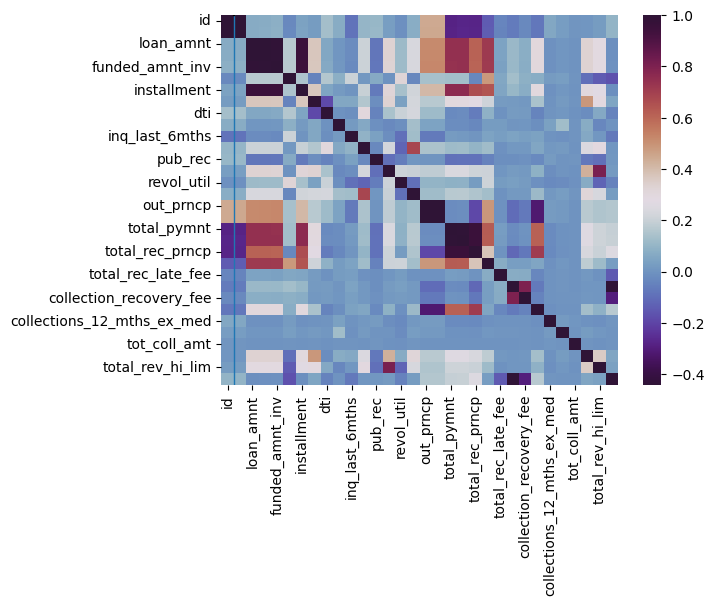

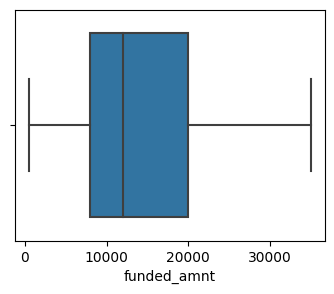

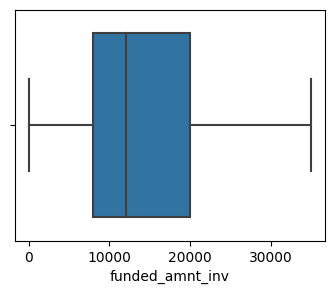

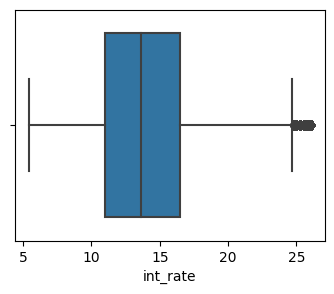

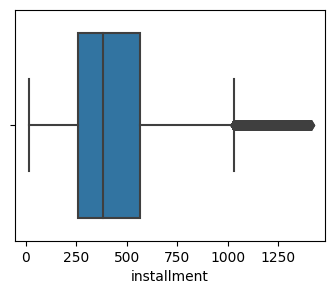

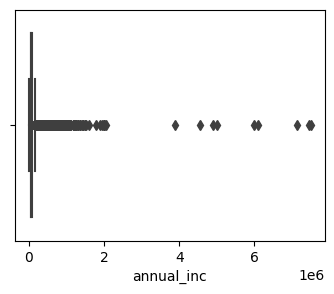

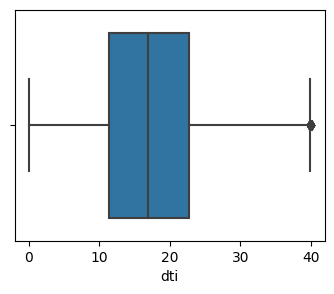

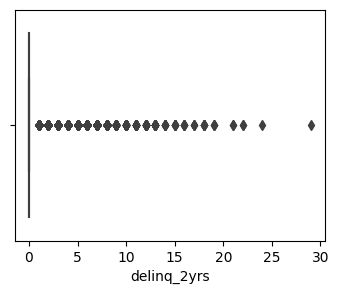

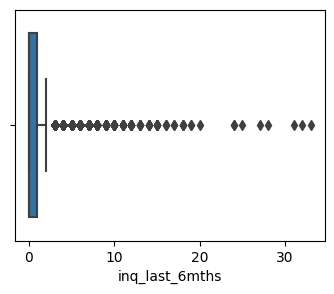

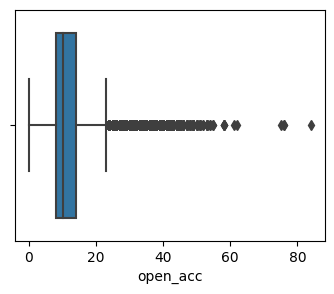

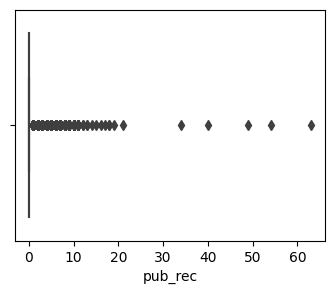

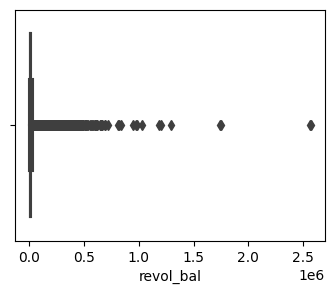

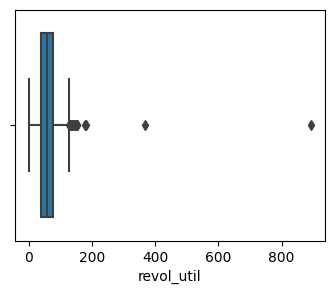

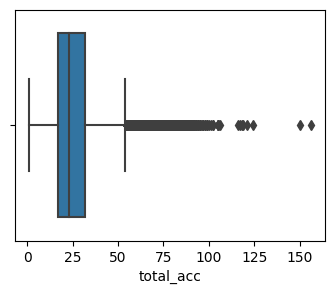

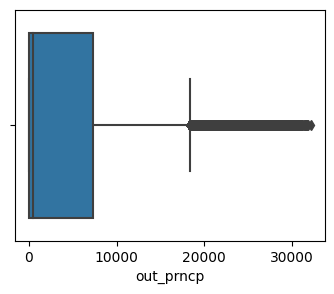

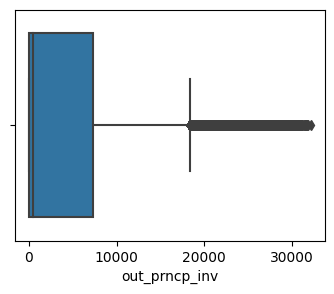

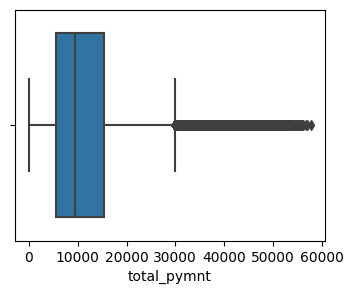

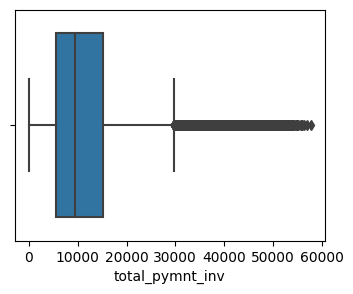

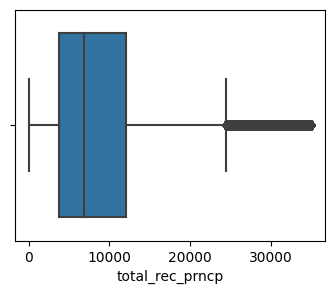

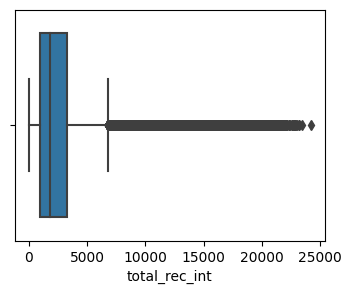

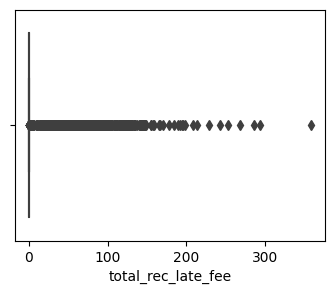

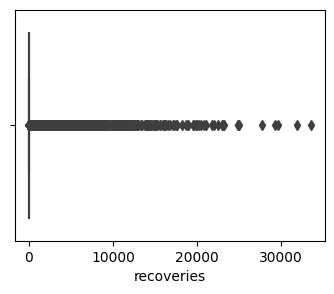

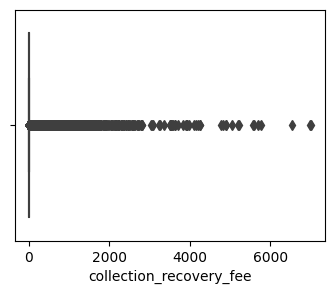

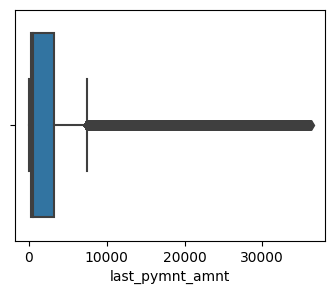

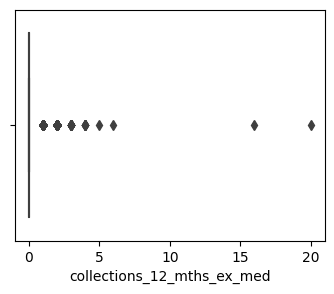

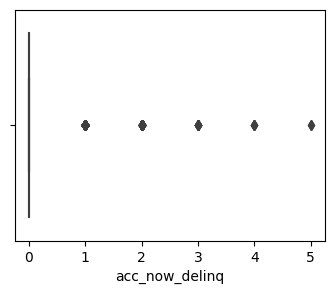

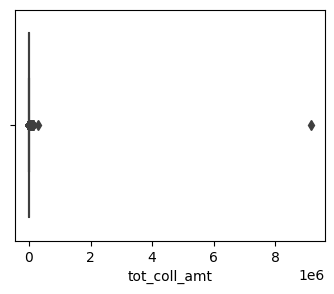

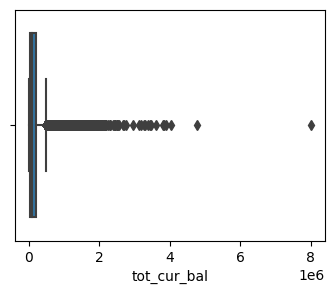

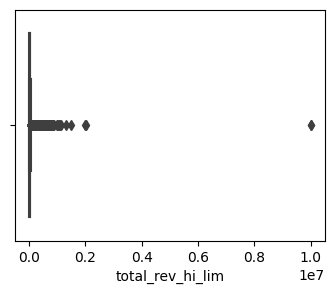

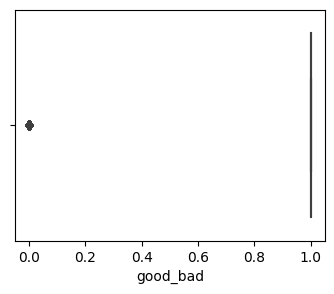

In [26]:
from pandas.api.types import is_numeric_dtype

for col in loan_df.iloc[:,3:]:
    if is_numeric_dtype(loan_df[col]):
        plt.figure(figsize=(4, 3))
        sns.boxplot(data = loan_df, x = col)
        plt.show();
        # Consigo colocar um do lado do outro?
        
# The upper and lower limits are the IQR -> past them, everything is an outlier
# Cols:
# 'total_rev_hi_lim', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs'(tem mt zero... oq fazer?)
# , 'inq_last_6mths', 'open_acc', 'pub_rec'
# , 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp'
# , 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med'
# , 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'

# Fazer Robust Scaler nessas variáveis acima (outliers)
# RobustScaler = (x - median)/IQR


# Colunas esquisitas: 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'pub_rec' --> considerar OHE nessas

In [27]:
# Tests
loan_df['acc_now_delinq'].unique()

array([ 0.,  1., nan,  2.,  3.,  5.,  4.])

In [28]:
# sns.boxplot(data = loan_df, x = 'acc_now_delinq')
# plt.show()

loan_df['acc_now_delinq'].value_counts()

0.0    464524
1.0      1623
2.0        92
3.0        11
4.0         4
5.0         2
Name: acc_now_delinq, dtype: int64

In [29]:
# Selecting columns to transform with robust

columns_to_robust = ['total_rev_hi_lim', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'tot_coll_amt', 'acc_now_delinq', 'tot_cur_bal', 'total_rev_hi_lim']

In [30]:
columns_to_standardize = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv']

## Categorical Features

In [31]:
#### Balancear o dataset?
# Balancing strategies
# Oversampling of minority class
# Alternatively, Computation of new instances for the minority class
# Undersampling of majority class

# Use balancing techniques only on the training set to help the model learn about the minority class.
# The test set should remain representative of the real word.

### SMOTE?

### Encodings
# Ordinal Encoder -> se tiver lógica crescente entre as categorias
# One Hot Encoder -> se NÃO tiver lógica crescente entre as categorias


In [32]:
loan_df.select_dtypes('object').columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type'],
      dtype='object')

In [33]:
# Verificando variáveis

loan_df['verification_status'].unique()
loan_df.groupby('verification_status')['good_bad'].value_counts(normalize = True)

loan_df['pymnt_plan'].value_counts() # Muito fraca

# Purpose -> Boa, clusterizar
loan_df['purpose'].value_counts()
loan_df.groupby('purpose')['good_bad'].value_counts()
# loan_df.groupby('purpose')['good_bad'].value_counts(normalize = True)

# Title -> caótico. Drop
loan_df['title'].value_counts()

# earliest_cr_line -> data. Drop.
loan_df['earliest_cr_line'].value_counts()

# initial_list_status: w = whole; f = fractional 
loan_df['initial_list_status'].value_counts() # Incerto.

loan_df['application_type'].value_counts()

INDIVIDUAL    466285
Name: application_type, dtype: int64

In [34]:
# Drop!
loan_df.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'verification_status', 'loan_status', 'issue_d', 'pymnt_plan', 'url', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d', 'application_type'], inplace = True)

In [35]:
# Clusterizar emp_length
# Juntar NA + < 1yr
# 1 a 3 yrs...

In [36]:
# Clusterizar 'purpose'

In [37]:
columns_to_category = loan_df.select_dtypes('object').columns
columns_to_category

Index(['term', 'grade', 'emp_length', 'home_ownership', 'purpose'], dtype='object')

In [38]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   466285 non-null  int64  
 1   funded_amnt                 466285 non-null  int64  
 2   funded_amnt_inv             466285 non-null  float64
 3   term                        466285 non-null  object 
 4   int_rate                    466285 non-null  float64
 5   installment                 466285 non-null  float64
 6   grade                       466285 non-null  object 
 7   emp_length                  445277 non-null  object 
 8   home_ownership              466285 non-null  object 
 9   annual_inc                  466281 non-null  float64
 10  purpose                     466285 non-null  object 
 11  dti                         466285 non-null  float64
 12  delinq_2yrs                 466256 non-null  float64
 13  inq_last_6mths

In [39]:
# Writing treated dataframe
loan_df.to_csv('../raw_data/treated_df.csv', index = False)

## Preprocessing Pipeline

In [40]:
# loan_df = pd.read_csv('../raw_data/treated_df.csv')
y = loan_df[['good_bad']]
X = loan_df.drop(columns = 'good_bad')

In [46]:
X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,...,861.07,0.00,0.00,0.00,171.62,0.0,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,...,435.17,0.00,117.08,1.11,119.66,0.0,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,...,603.65,0.00,0.00,0.00,649.91,0.0,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,...,2209.33,16.97,0.00,0.00,357.48,0.0,0.0,NaN,NaN,NaN
4,3000,3000,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,...,1009.07,0.00,0.00,0.00,67.79,0.0,0.0,NaN,NaN,NaN


In [47]:
y.head()

,good_bad
0,1
1,0
2,1
3,1
4,1


In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# This stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.

# For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

# Ou:
# from sklearn.model_selection import StratifiedShuffleSplit

# stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

((373028, 34), (93257, 34), (373028, 1), (93257, 1))

In [52]:
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import OneHotEncoder


# Impute then scale numerical values: 
# Features with no outliers
standard_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('standard_scaler', StandardScaler())
])

# Features with outliers
robust_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('robust_scaler', RobustScaler())
])

# Encode categorical values
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Parallelize the transformers
preprocessor = ColumnTransformer([
    ('standard_scaler', standard_transformer, columns_to_standardize), 
    ('robust_scaler', robust_transformer, columns_to_robust),
    ('cat_transformer', cat_transformer, columns_to_category)
])

In [53]:
 # Visualizing Pipelines in HTML
from sklearn import set_config; set_config(display='diagram')
preprocessor

ColumnTransformer(transformers=[('standard_scaler',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('standard_scaler',
                                                  StandardScaler())]),
                                 ['loan_amnt', 'funded_amnt',
                                  'funded_amnt_inv']),
                                ('robust_scaler',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('robust_scaler',
                                                  RobustScaler())]),
                                 ['total_rev_hi_lim', 'int_rate', 'installment',
                                  'annual_inc...
                                  'total_pymnt_inv', 'total_rec_prncp',
                                  'total_rec_int', 'total_rec_late_fee',
                                  'recoveries', 'collection_recovery_fee',
                                  'last_pymnt_amnt',
                                  'collections_12_mths_ex_med', 'tot_coll_amt',
                                  'acc_now_delinq', 'tot_cur_bal',
                                  'total_rev_hi_lim']),
                                ('cat_transformer',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 Index(['term', 'grade', 'emp_length', 'home_ownership', 'purpose'], dtype='object'))])

In [55]:
X_train_transformed = preprocessor.fit_transform(X_train)

pd.DataFrame(
    X_train_transformed, 
    columns=preprocessor.get_feature_names_out()
).head()

,standard_scaler__loan_amnt,standard_scaler__funded_amnt,standard_scaler__funded_amnt_inv,robust_scaler__total_rev_hi_lim,robust_scaler__int_rate,robust_scaler__installment,robust_scaler__annual_inc,robust_scaler__dti,robust_scaler__delinq_2yrs,robust_scaler__inq_last_6mths,...,cat_transformer__purpose_home_improvement,cat_transformer__purpose_house,cat_transformer__purpose_major_purchase,cat_transformer__purpose_medical,cat_transformer__purpose_moving,cat_transformer__purpose_other,cat_transformer__purpose_renewable_energy,cat_transformer__purpose_small_business,cat_transformer__purpose_vacation,cat_transformer__purpose_wedding
0,0.685189,0.689363,0.695902,1.124915,1.598182,0.571495,-0.068182,1.042982,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.810699,-0.808779,-0.798044,-0.835946,0.058182,-0.388372,-0.477273,1.091228,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.891550,1.897543,1.900696,3.766916,0.834545,2.282291,7.659091,-0.938596,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.521172,-0.518816,-0.508893,-0.546977,0.389091,-0.095381,-0.068182,-0.442105,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.443917,0.447728,0.454943,-0.846266,0.354545,0.803091,0.660375,-0.289474,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Full preprocessing pipeline
from sklearn.compose import make_column_selector

num_transformer = make_pipeline(SimpleImputer(), StandardScaler())
num_col = make_column_selector(dtype_include=['float64'])

cat_transformer = OneHotEncoder()
cat_col = make_column_selector(dtype_include=['object','bool'])

preproc_basic = make_column_transformer(
    (num_transformer, num_col),
    (cat_transformer, cat_col),
    remainder='passthrough'
)

preproc_full = make_union(preproc_basic, bmi_age_ratio_constructor)

preproc_full